In [9]:
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np

# Generate a sample signal
np.random.seed(42)
signal = np.sin(2 * np.pi * 10 * np.linspace(0, 1, 124)) + np.random.normal(0, 0.2, 124)

# Perform wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet, level=7)

# Prepare graph data
def build_wavelet_graph(coeffs):
    # Determine the maximum length of all coefficient arrays
    max_length = max(len(c) for c in coeffs)

    # Pad all coefficients to have the same length
    padded_coeffs = [np.pad(c, (0, max_length - len(c)), mode='constant') for c in coeffs]

    # Initialize node features and edges
    node_features = []
    edges = []
    current_node = 0

    # Add the root node (Signal)
    node_features.append(padded_coeffs[0].tolist())  # Root node features

    # Build graph recursively
    for level, c in enumerate(padded_coeffs[1:], start=1):
        parent_node = current_node  # Parent is the previous approximation/detail
        for coeff in c:
            # Pad single coefficient to match max_length
            padded_feature = np.pad([coeff], (0, max_length - 1), mode='constant')
            node_features.append(padded_feature.tolist())  # Add as node feature
            edges.append([parent_node, len(node_features) - 1])  # Edge to child
        current_node += 1  # Move to next node

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

# Build the graph
wavelet_graph = build_wavelet_graph(coeffs)

# Display the graph data
print(wavelet_graph)


Data(x=[435, 62], edge_index=[2, 434])


c:\Users\WD\anaconda3\envs\torch_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [10]:
wavelet_graph.x

tensor([[-0.3790,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1019,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2930,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1370,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0509,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [11]:
wavelet_graph.edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2

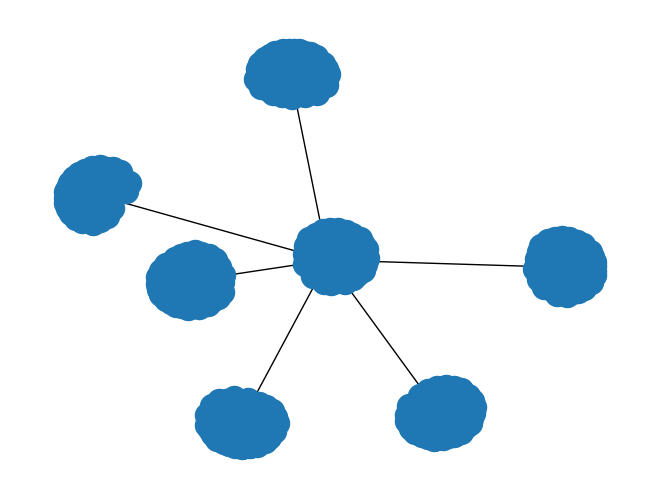

In [12]:

g = torch_geometric.utils.to_networkx(wavelet_graph , to_undirected=True)
nx.draw(g)

In [13]:
help(torch_geometric.utils.to_networkx
     )

Help on function to_networkx in module torch_geometric.utils.convert:

to_networkx(data: Union[ForwardRef('torch_geometric.data.Data'), ForwardRef('torch_geometric.data.HeteroData')], node_attrs: Optional[Iterable[str]] = None, edge_attrs: Optional[Iterable[str]] = None, graph_attrs: Optional[Iterable[str]] = None, to_undirected: Union[bool, str, NoneType] = False, to_multi: bool = False, remove_self_loops: bool = False) -> Any
    Converts a :class:`torch_geometric.data.Data` instance to a
    :obj:`networkx.Graph` if :attr:`to_undirected` is set to :obj:`True`, or
    a directed :obj:`networkx.DiGraph` otherwise.
    
    Args:
        data (torch_geometric.data.Data or torch_geometric.data.HeteroData): A
            homogeneous or heterogeneous data object.
        node_attrs (iterable of str, optional): The node attributes to be
            copied. (default: :obj:`None`)
        edge_attrs (iterable of str, optional): The edge attributes to be
            copied. (default: :obj:`No

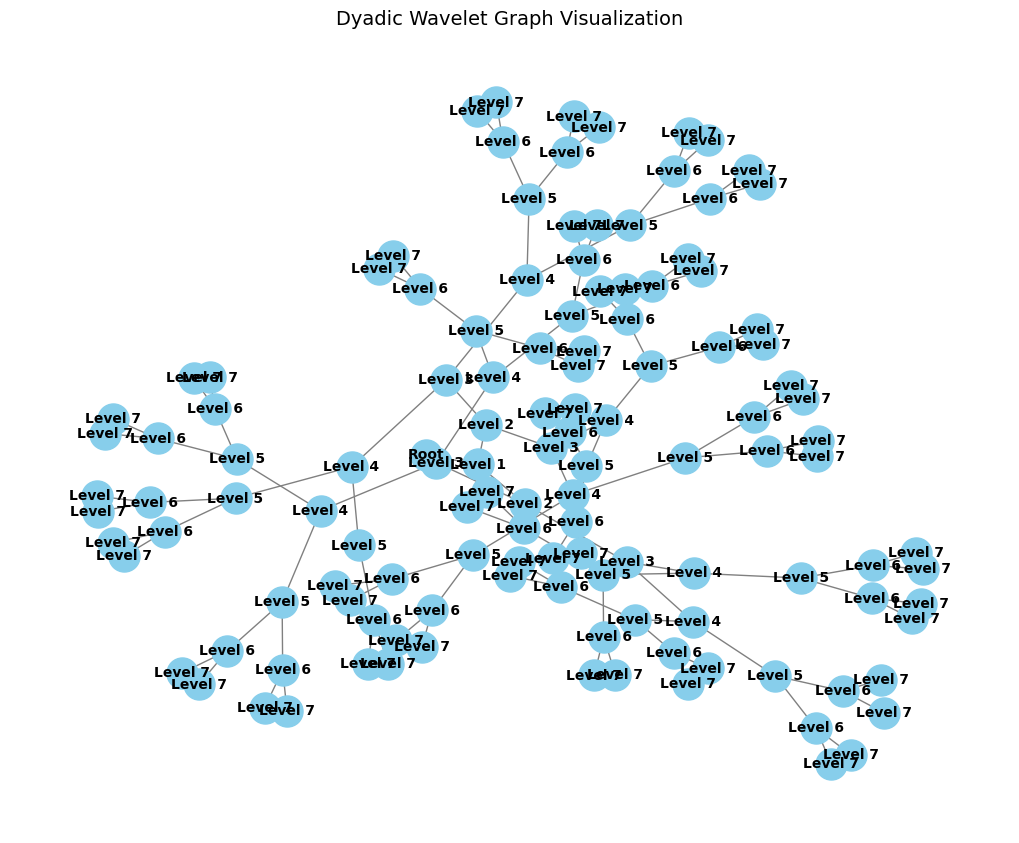

In [23]:
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample signal
np.random.seed(42)
signal = np.sin(2 * np.pi * 10 * np.linspace(0, 1, 124)) + np.random.normal(0, 0.2, 124)

# Perform wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet, level=7)

# Prepare graph data
def build_dyadic_wavelet_graph(coeffs):
    """
    Build a dyadic graph from wavelet decomposition coefficients.
    Each node at level n is connected to two nodes at level n+1.
    """
    max_length = max(len(c) for c in coeffs)  # Determine max length of coefficient arrays
    node_features = []  # To store node features
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_feature = np.pad(coeffs[0], (0, max_length - len(coeffs[0])), mode='constant')
    node_features.append(root_feature.tolist())
    node_labels[current_node] = "Root"

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(coeffs[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    padded_feature = np.pad([c[coeff_index]],
                                            (0, max_length - 1), mode='constant')
                    node_features.append(padded_feature.tolist())
                    node_labels[current_node] = f"Level {level}"
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), node_labels

# Build the dyadic wavelet graph
wavelet_graph, node_labels = build_dyadic_wavelet_graph(coeffs)

# Convert to NetworkX for visualization
g = torch_geometric.utils.to_networkx(wavelet_graph, to_undirected=True)

# Draw the graph with improved visualization
def draw_dyadic_wavelet_graph(g, node_labels):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(g)  # Layout for consistent visualization
    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=500, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray"
    )
    plt.title("Dyadic Wavelet Graph Visualization", fontsize=14)
    plt.show()

# Visualize the wavelet graph
draw_dyadic_wavelet_graph(g, node_labels)


Graph with 1 nodes and 0 edges


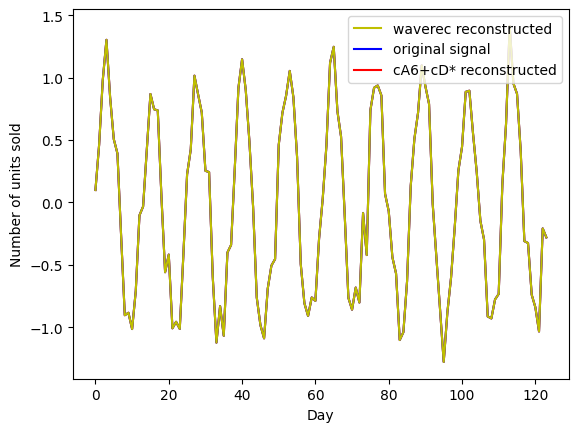

In [22]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

data =signal
n = len(data)
wl = pywt.Wavelet("db1")
coeff_all = pywt.wavedec(data, wl, level=6)
cA6, cD6,cD5, cD4, cD3, cD2, cD1= coeff_all
omp0 = pywt.upcoef('a',cA6,wl,level=6)[:n]
omp1 = pywt.upcoef('d',cD1,wl,level=1)[:n]
omp2 = pywt.upcoef('d',cD2,wl,level=2)[:n]
omp3 = pywt.upcoef('d',cD3,wl,level=3)[:n]
omp4 = pywt.upcoef('d',cD4,wl,level=4)[:n]
omp5 = pywt.upcoef('d',cD5,wl,level=5)[:n]
omp6 = pywt.upcoef('d',cD6,wl,level=6)[:n]

#cA6cD_approx = omp0 + omp1 + omp2 + omp3 + omp4+ omp5 + omp6
#plt.figure(figsize=(18,9))
recon = pywt.waverec(coeff_all, wavelet= wl)
p1, =plt.plot(omp0 + omp6 + omp5 + omp4 + omp3 + omp2 + omp1,'r')
p2, =plt.plot(data, 'b')
p3, =plt.plot(recon, 'y')

plt.xlabel('Day')
plt.ylabel('Number of units sold')
plt.legend([p3,p2,p1], ["waverec reconstructed","original signal", "cA6+cD* reconstructed"])
plt.show()